# Reference Space

This notebook contains example code demonstrating the use of the StructureTree and ReferenceSpace classes. These classes provide methods for interacting with the 3D spaces to which Allen Institute data and atlases are registered.

The main entry point will be through the `ReferenceSpaceCache` class. The `ReferenceSpaceCache` class has methods for downloading, storing, and constructing StructureTrees, annotations, and ReferenceSpaces.

* <a href='#Constructing-a-StructureTree'>Constructing a StructureTree</a>
* <a href='#Using-a-StructureTree'>Using a StructureTree</a>
* <a href='#Downloading-an-annotation-volume'>Downloading an annotation volume</a>
* <a href='#Constructing-a-ReferenceSpace'>Constructing a ReferenceSpace</a>
* <a href='#Using-a-ReferenceSpace'>Using a ReferenceSpace</a>
* <a href='#Exporting'>Exporting</a>

## Constructing a StructureTree

A StructureTree object is a wrapper around a structure graph - a list of dictionaries documenting brain structures and their containment relationships. To build a structure tree, you will first need to obtain a structure graph. The `ReferenceSpaceCache` takes care of that for you.

For a list of atlases and corresponding structure graph ids, see [here](http://help.brain-map.org/display/api/Atlas+Drawings+and+Ontologies).

In [60]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache

reference_space_key = 'annotation/ccf_2017'
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest='manifest.json')
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 

In [61]:
# now let's take a look at a structure
tree.get_structures_by_name(['Dorsal auditory area'])

[{'acronym': 'AUDd',
  'graph_id': 1,
  'graph_order': 122,
  'id': 1011,
  'name': 'Dorsal auditory area',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 247, 1011],
  'structure_set_ids': [112905828,
   688152357,
   691663206,
   687527945,
   12,
   184527634,
   167587189,
   114512891],
  'rgb_triplet': [1, 147, 153]}]

The fields are:
    * acronym: a shortened name for the structure
    * rgb_triplet: each structure is assigned a consistent color for visualizations
    * graph_id: the structure graph to which this structure belongs
    * graph_order: each structure is assigned a consistent position in the flattened graph
    * id: a unique integer identifier
    * name: the full name of the structure
    * structure_id_path: traces a path from the root node of the tree to this structure
    * structure_set_ids: the structure belongs to these predefined groups

## Using a StructureTree

In [62]:
# get a structure's parent
tree.parents([1011])

[{'acronym': 'AUD',
  'graph_id': 1,
  'graph_order': 121,
  'id': 247,
  'name': 'Auditory areas',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 247],
  'structure_set_ids': [3, 112905828, 691663206, 12, 184527634, 114512891],
  'rgb_triplet': [1, 147, 153]}]

In [63]:
# get a dictionary mapping structure ids to names

name_map = tree.get_name_map()
name_map[247]

'Auditory areas'

In [64]:
# ask whether one structure is contained within another

structure_id_a = 385
structure_id_b = 247

is_desc = '' if tree.structure_descends_from(structure_id_a, structure_id_b) else ' not'
print( '{0} is{1} in {2}'.format(name_map[structure_id_a], is_desc, name_map[structure_id_b]) )

Primary visual area is not in Auditory areas


In [65]:
# build a custom map that looks up acronyms by ids
# the syntax here is just a pair of node-wise functions. 
# The first one returns keys while the second one returns values

acronym_map = tree.value_map(lambda x: x['id'], lambda y: y['acronym'])
print( acronym_map[structure_id_a] )

VISp


## Downloading an annotation volume

You can obtain annotation volumes through the `ReferenceSpaceCache` which stores a nrrd file containing the Allen Common Coordinate Framework annotation on your hard drive. Above we set the resolution for annotations when we initialized the `ReferenceSpaceCache` to 25-micron isometric spacing. The orientation of this space is:
    * Anterior -> Posterior
    * Superior -> Inferior
    * Left -> Right

In [66]:
import os

annotation, meta = rspc.get_annotation_volume()
# The file should appear in the reference space key directory
os.listdir(reference_space_key)

['annotation_25.nrrd']

## Constructing a ReferenceSpace

A reference space is built from a structure tree and an annotation volume. We can obtain our ReferenceSpace object using `ReferenceSpaceCache` which will load everything from the cache since we have already downloaded the files for use above.

In [67]:
rsp = rspc.get_reference_space()

KeyboardInterrupt: 

## Using a ReferenceSpace

#### making structure masks

The simplest use of a Reference space is to build binary indicator masks for structures or groups of structures.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# A complete mask for one structure
whole_cortex_mask = rsp.make_structure_mask([315])

# view in coronal section
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(whole_cortex_mask[150, :], interpolation='none', cmap=plt.cm.afmhot)

KeyboardInterrupt: 

What if you want a mask for a whole collection of ontologically disparate structures? Just pass more structure ids to make_structure_masks:

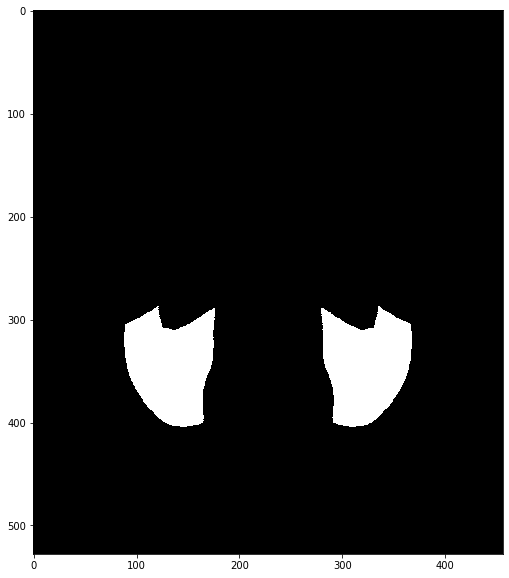

In [ ]:
# This gets all of the structures targeted by the Allen Brain Observatory project
brain_observatory_structures = rsp.structure_tree.get_structures_by_set_id([514166994])
brain_observatory_ids = [st['id'] for st in brain_observatory_structures]

brain_observatory_mask = rsp.make_structure_mask(brain_observatory_ids)

# view in horizontal section
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(brain_observatory_mask[:, 40, :], interpolation='none', cmap=plt.cm.afmhot)

You can also make and store a number of structure_masks at once, however this is only accessible using the `ReferenceSpace` class directly:

In [ ]:
import functools
from allensdk.core.reference_space import ReferenceSpace

# Define a wrapper function that will control the mask generation. 
# This one checks for a nrrd file in the specified base directory 
# and builds/writes the mask only if one does not exist
annotation_dir = 'annotation'
mask_writer = functools.partial(ReferenceSpace.check_and_write, annotation_dir)
    
# many_structure_masks is a generator - nothing has actrually been run yet
mask_generator = rsp.many_structure_masks([385, 1097], mask_writer)

# consume the resulting iterator to make and write the masks
for structure_id in mask_generator:
    print( 'made mask for structure {0}.'.format(structure_id) ) 

os.listdir(annotation_dir)

made mask for structure 385.
made mask for structure 1097.


['ccf_2017', 'structure_1097.nrrd', 'structure_385.nrrd']

#### Removing unassigned structures

A structure graph may contain structures that are not used in a particular reference space. Having these around can complicate use of the reference space, so we generally want to remove them.

We'll try this using "Somatosensory areas, layer 6a" as a test case. In the 2016 ccf space, this structure is unused in favor of finer distinctions (e.g. "Primary somatosensory area, barrel field, layer 6a").

In [ ]:
# Double-check the voxel counts
no_voxel_id = rsp.structure_tree.get_structures_by_name(['Somatosensory areas, layer 6a'])[0]['id']
print( 'voxel count for structure {0}: {1}'.format(no_voxel_id, rsp.total_voxel_map[no_voxel_id]) )

# remove unassigned structures from the ReferenceSpace's StructureTree
rsp.remove_unassigned()

# check the structure tree
no_voxel_id in rsp.structure_tree.node_ids()

voxel count for structure 12997: 0


False

#### View a slice from the annotation

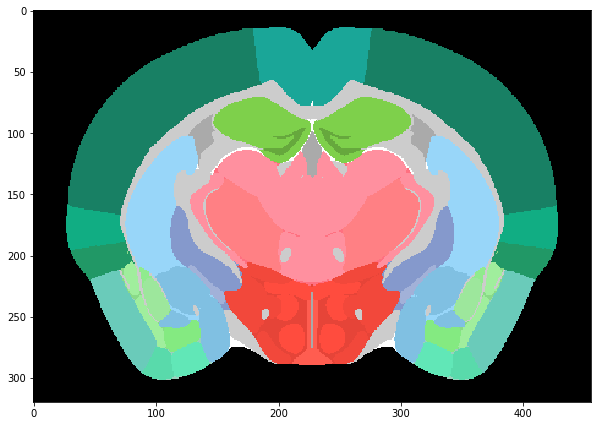

In [ ]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(rsp.get_slice_image(0, 6500), interpolation='none')

#### Downsample the space

If you want an annotation at a resolution we don't provide, you can make one with the downsample method.

In [ ]:
import warnings

target_resolution = [75, 75, 75]

# in some versions of scipy, scipy.ndimage.zoom raises a helpful but distracting 
# warning about the method used to truncate integers. 
warnings.simplefilter('ignore')

sf_rsp = rsp.downsample(target_resolution)

# re-enable warnings
warnings.simplefilter('default')

print( rsp.annotation.shape )
print( sf_rsp.annotation.shape )

(528, 320, 456)
(176, 107, 152)


Now view the downsampled space:

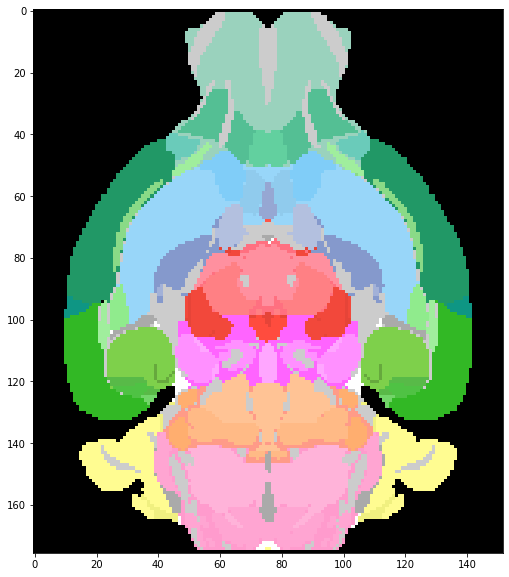

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(sf_rsp.get_slice_image(1, 5000), interpolation='none')

## Exporting

if you want to work with our reference space data using tools made by vendors other than the Allen Institute for Brain Science, you may need to do some conversion work. The AllenSDK contains a few convenience functions which implement common conversions. If you don't see the one you need, mention it on [our issues page](https://github.com/alleninstitute/allensdk/issues).

#### ITKSnap

[ITKSnap](http://www.itksnap.org/pmwiki/pmwiki.php) is a tool for viewing and segmenting biological volume data. Our annotation team uses it to draw CCF annotations. If you have data aligned to one of our reference spaces, you can use the AllenSDK to export an ITKSnap compatible segmentation volume and corresponding label description file.

Note: our structure ids are 32-bit unsigned integers and may exceed ITKSnap's maximum allowable label value (65535). If any of the ids in a structure tree do exceed this value, the `write_itksnap_labels` method will automatically remap the ids to a set of smaller numbers.

In [ ]:
# using the downsampled annotations
hm_rsp = rsp.downsample([100, 100, 100])
hm_rsp.write_itksnap_labels('ccf_2017_itksnap.nrrd', 'ccf_2017_itksnap_labels.txt')

C:\Users\imageprocessing\Anaconda3\envs\allen\lib\site-packages\pandas\core\internals\construction.py:588: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\imageprocessing\Anaconda3\envs\allen\lib\site-packages\pandas\core\indexes\base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\

(1899, 1822)
(1899, 1822)


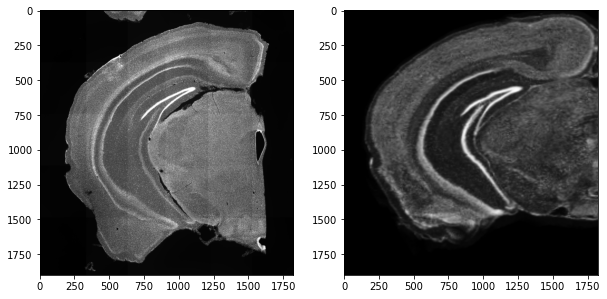

In [78]:
import numpy as np
import cv2
import nrrd
import matplotlib.pyplot as plt

data, header = nrrd.read("ara_nissl/ara_nissl_25.nrrd")
target_resolution = [75, 75, 75]
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
section = cv2.imread('R3_s038.png')
section = cv2.cvtColor( section, cv2.COLOR_RGB2GRAY )
atlas = np.squeeze(data[328,:,:228,])
atlas = cv2.normalize(atlas, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

atlasResize = cv2.resize(atlas, (section.shape[1], section.shape[0]) )
print(section.shape)
print(atlasResize.shape)
def homography( zstackKeyPoints, motherKeyPoints, matched ):
    ''' Finds homography between two images to warp images for alignment. '''
    # Empty arrays to fill in with matched points
    zstackPoints = motherPoints = np.zeros((len(matched), 1, 2), dtype=np.float32)

    for i in range(0,len(matched)): # We train the detector with the kp of the mother image against the zstack
        zstackPoints[i] = zstackKeyPoints[matched[i].queryIdx].pt
        motherPoints[i] = motherKeyPoints[matched[i].trainIdx].pt

    # Using RANSAC to approximate the locations of absolute homography between images
    homography, mask = cv2.findHomography(zstackPoints, motherPoints, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography   

def align( im1, im2 ):
    ''' Aligns the images of each channel in the TIFF using ORB (Oriented FAST and Rotated BRIEF). '''
    # ORB is fast and works well for most images (also not patented)
    detector = cv2.ORB_create(100000)

    mother = im1
    motherKeyPoints, motherDesc = detector.detectAndCompute(mother, None)

    thisStack = im2
    zstackKeyPoints, zstackDesc = detector.detectAndCompute(thisStack, None)
    # If we are using ORB then we should just brute force it
    # Hamming distance and crosscheck for feature matching
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    raw = matcher.match(zstackDesc, motherDesc)
    sortedRaw = sorted(raw, key=lambda match: match.distance)
    topMatches = sortedRaw
    # Find the homography of these two images
    hom = homography(zstackKeyPoints, motherKeyPoints, topMatches)
    # Now actually do the alignment step
    
    alignedImage = cv2.warpPerspective(thisStack, hom, (thisStack.shape[1], thisStack.shape[0]), flags=cv2.INTER_LINEAR)

    return alignedImage

atlasWarped = align(section, atlasResize)


ax1.imshow(section, cmap='gray')
ax2.imshow(atlasWarped, cmap='gray')
ax3.imshow(atlasResize)